In [36]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from latex import latexify, format_axes
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [2]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda


## **Wonderland Corpus**

In [3]:
fileWonder = open("wonderland.txt", "r")
wonder = fileWonder.read()
print(wonder[:1000])
new_wonder = ""
for char in wonder:
    if char in ['ù', '—', '‘', '’', '“', '”']:
        continue
    new_wonder += char

characters = sorted(list(set(new_wonder)))
print(len(new_wonder))
print(len(characters))
print(characters)

CHAPTER I.
Down the Rabbit-Hole


Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into
the book her sister was reading, but it had no pictures or
conversations in it, “and what is the use of a book,” thought Alice
“without pictures or conversations?”

So she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy and stupid), whether the pleasure of
making a daisy-chain would be worth the trouble of getting up and
picking the daisies, when suddenly a White Rabbit with pink eyes ran
close by her.

There was nothing so _very_ remarkable in that; nor did Alice think it
so _very_ much out of the way to hear the Rabbit say to itself, “Oh
dear! Oh dear! I shall be late!” (when she thought it over afterwards,
it occurred to her that she ought to have wondered at this, but at the
time it all seemed quite natural); but when the Rabbit actually _took a
watch out of its w

In [4]:
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["+"] = 0 ## Pad Character
itos = {i : s for s, i in stoi.items()}
pprint(itos)

{0: '+',
 1: '\n',
 2: ' ',
 3: '!',
 4: '(',
 5: ')',
 6: '*',
 7: ',',
 8: '-',
 9: '.',
 10: ':',
 11: ';',
 12: '?',
 13: 'A',
 14: 'B',
 15: 'C',
 16: 'D',
 17: 'E',
 18: 'F',
 19: 'G',
 20: 'H',
 21: 'I',
 22: 'J',
 23: 'K',
 24: 'L',
 25: 'M',
 26: 'N',
 27: 'O',
 28: 'P',
 29: 'Q',
 30: 'R',
 31: 'S',
 32: 'T',
 33: 'U',
 34: 'V',
 35: 'W',
 36: 'X',
 37: 'Y',
 38: 'Z',
 39: '[',
 40: ']',
 41: '_',
 42: 'a',
 43: 'b',
 44: 'c',
 45: 'd',
 46: 'e',
 47: 'f',
 48: 'g',
 49: 'h',
 50: 'i',
 51: 'j',
 52: 'k',
 53: 'l',
 54: 'm',
 55: 'n',
 56: 'o',
 57: 'p',
 58: 'q',
 59: 'r',
 60: 's',
 61: 't',
 62: 'u',
 63: 'v',
 64: 'w',
 65: 'x',
 66: 'y',
 67: 'z'}


![](./MLPToken.svg)

## Generating the Training Samples

![](./media/MLPToken.svg)

In [5]:
block_size = 100
X, Y = [], []
context = [0] * block_size
for idx in range(len(new_wonder)):
  ix = stoi[new_wonder[idx]]
  X.append(context)
  Y.append(ix)
  # print(''.join(itos[i] for i in context), '--->', itos[ix])
  context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [6]:
X.shape, Y.shape

(torch.Size([140763, 100]), torch.Size([140763]))

In [7]:
# Embedding layer for the context
emb_dim = 256
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [8]:
emb.weight.shape

torch.Size([68, 256])

## Function to visualize the embedding in 2d space using **t-SNE**

<Axes: >

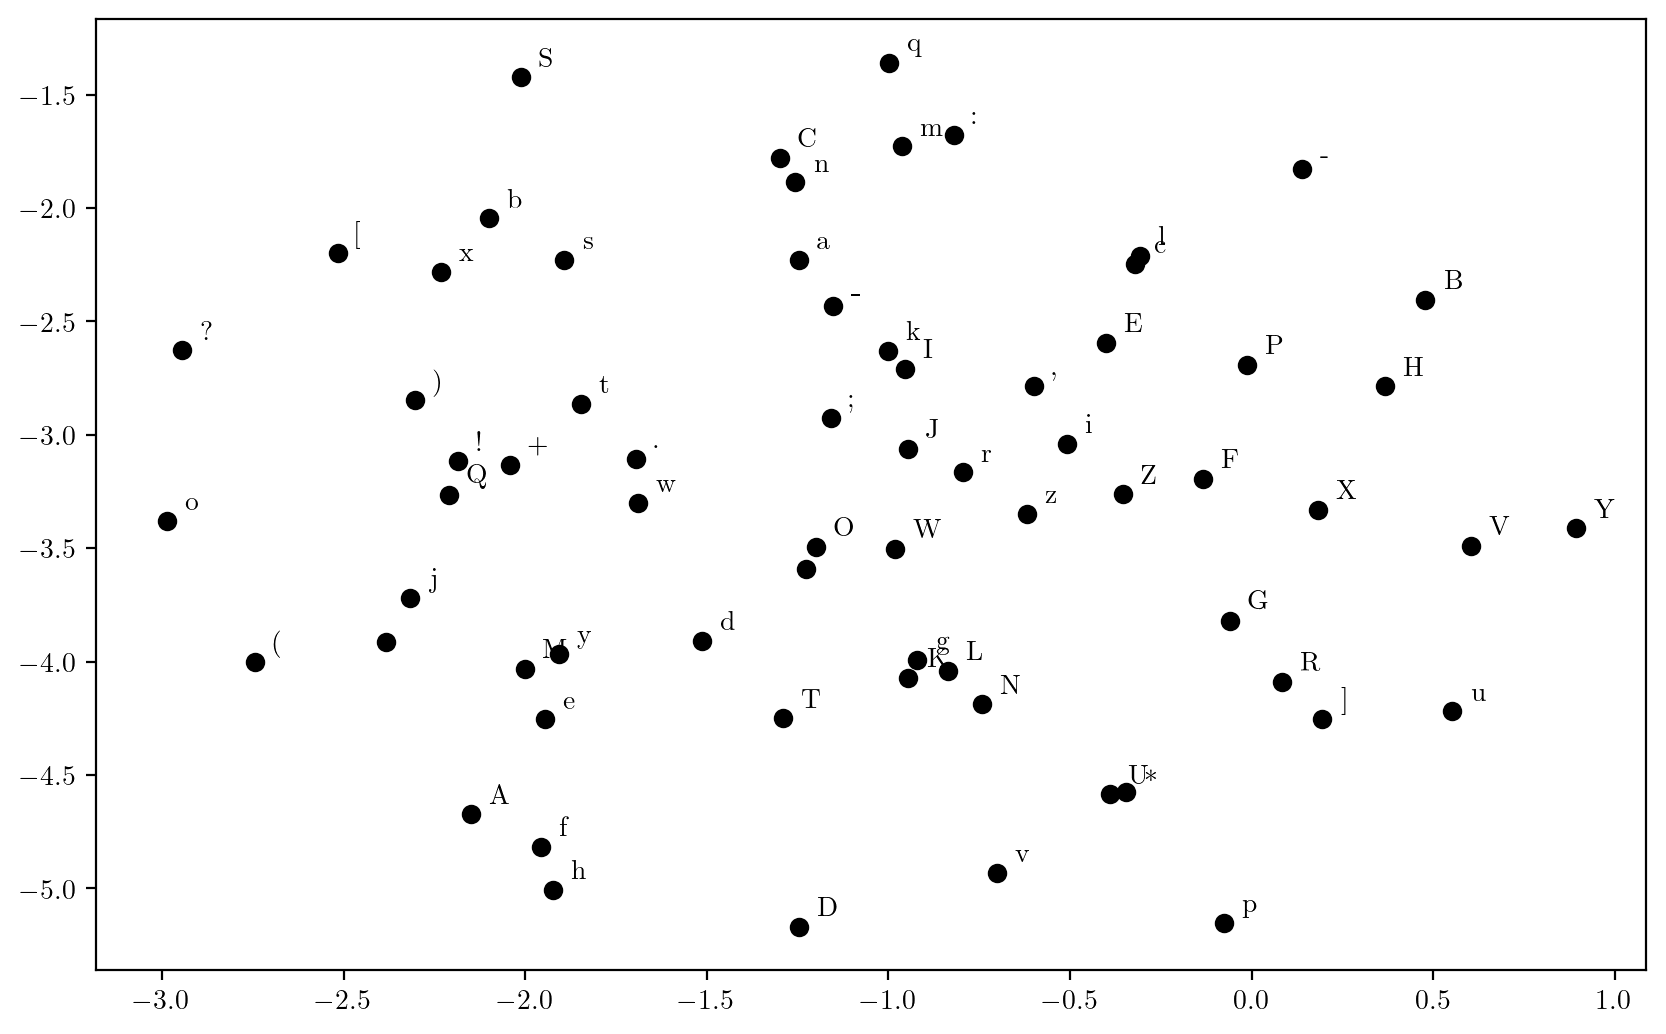

In [9]:
latexify(columns = 2, fig_width = 10)
def plot_emb(emb, itos, ax=None):
    if emb.weight.shape[1] != 2:
      tsne = TSNE(n_components = 2)
      emb_new = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        if emb.weight.shape[1] == 2:
          x, y = emb.weight[i].detach().cpu().numpy()
          ax.scatter(x, y, color='k')
          ax.text(x + 0.05, y + 0.05, itos[i])
        else:
          x, y = emb_new[i]
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

## Structure of the **MLP**

![Alt](./media/Embed.svg)
![Alt](./media/ModelEmbed.svg)

In [10]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.tanh(self.lin1(x))
    x = self.lin2(x)
    return x

In [11]:
model = NextChar(block_size, len(stoi), emb_dim, 100).to(device)
model = torch.compile(model)

In [12]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([68, 256])
_orig_mod.lin1.weight torch.Size([100, 25600])
_orig_mod.lin1.bias torch.Size([100])
_orig_mod.lin2.weight torch.Size([68, 100])
_orig_mod.lin2.bias torch.Size([68])


## Generating names from untrained model

In [14]:
import warnings
warnings.filterwarnings("ignore")

g = torch.Generator()
g.manual_seed(4200)
def generate_text(model, itos, stoi, block_size, max_len, start_str = None):

    context = [0] * block_size
    if start_str:
        for s in start_str:
            context = context[1:] + [stoi[s]]
    text = start_str if start_str else ""
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text

my_str = generate_text(model, itos, stoi, block_size, 1000, "This is ")
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(decoded_string)

This is tAwW(tg-U-K!OL;I(V RvPqA?YdiSNkoNv-
tIwvKqXd:kAKNMQBu;LMFVsD+aYv![oDMGiVsbl Pdpb)ylZ?YsFihFKxk*So]wjXc_No:DP*KQl
XOB(j)
qQh)hl-a_X
As*ys;)qVyx_NE(gmLqctf!hIB!G.U(ygrS,VoRdolA_lBv

_owXWUV (cesEbgRb)GI.nuiW,Uv;RrsVRG.nmpYzL!YjkthecMI_Cf!h?[quVnQYmo:glk;gyA:SwAAxRT[U
lbPKjabToH !gPQw*?rMjzo.fHIdpsXwudVXdr.F)jhfhRSWZHQO+D.uS)eQJGx +Ll[]IKYM..sFLSK] F j Yb?gyuOR*Ksiok
b]wtz+.S-!*
TGoqnNtyQ!-I;EFvw
+
rscLWnnbmVBltjtWwJr.:(p_N NgnoknYHsUL(VDfkXr;S_bJ?R,O.ndH*Jlap?_G
XrL[pG.r-EXFH:yYVL rIeWx]mgh
x(..Kl;PmFXa)YSv!OU(ESprT;pM)gJZ)fO*)gLhnb;dLOqeTczv_x)HYxkpMLIuoaUoxyVRd-Ma,
cGT)-IgJhD-ukG(]cB+H, Vc(MQ[jez+NQrxOfVpNGeqS]KSL-DEcAZc+TItCU];,?KUj[zA_cj(hGK+zV-bR;TWocSZRFGht(KYGsUsIgf)*Dfoa-I:ilJcLWr+jNG?tEkXRQI.imMjxbW bYUszkGYDvmNMr.[uviozU-rRgxqYNZ,w!c*nqnfmqiHU;EQ!izev:nfSbynFXQ;lPooE*yNjC+uMI.QYn,iOa]G,I_hyEX. m,QQu(GsjpmnC *ApA).RDnpysTfM,KBfvtN
[:Y- Z]EZZdpOY;V.JMJgNAlMVQi)Nb?bh(cUhCSp aAZHaPsWXDGL;Tmm!SMZFXrlSPdFOSWjBuvOcVLSLinZ: RW MlrBesoY--vLKOH.RdnOq(DWCopvD[WFvtuSKQ*n )n[k?Y]Z,i

## Model Training

In [15]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr = 0.02)
batch_size = 4096
print_every = 100
for epoch in range(10000):
  for i in range(0, X.shape[0], batch_size):
      x = X[i : i + batch_size]
      y = Y[i : i + batch_size]
      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      loss.backward()
      opt.step()
      opt.zero_grad()
  if epoch % print_every == 0:
    print(epoch, loss.item())

0 3.086905002593994
100 1.7679665088653564
200 1.4825036525726318
300 1.2679094076156616
400 1.1270474195480347
500 1.0195372104644775
600 0.9762232303619385
700 0.9862545132637024


KeyboardInterrupt: 

## **Saving the model**

In [16]:
torch.save(model.state_dict(), "model.pth")

In [17]:
model.state_dict()

OrderedDict([('_orig_mod.emb.weight',
              tensor([[-0.3274, -1.0275, -0.3085,  ...,  0.4344,  0.9469,  0.8582],
                      [ 0.8353,  0.0723, -0.6750,  ..., -0.8716, -0.0754,  0.3752],
                      [ 0.2292,  0.0518, -0.5235,  ..., -0.0557, -0.1448, -0.3354],
                      ...,
                      [-2.2480, -1.0378,  0.9863,  ...,  0.4594,  2.7733, -3.5141],
                      [-0.2911, -0.4043,  0.3279,  ...,  0.8536,  0.2107,  0.0659],
                      [ 0.3842,  2.1537, -1.0786,  ...,  2.7750,  4.2318,  2.5672]],
                     device='cuda:0')),
             ('_orig_mod.lin1.weight',
              tensor([[-0.4815,  0.5634, -0.0868,  ..., -1.8484, -2.8559, -4.0223],
                      [-1.5611, -0.3313, -0.3688,  ..., -0.8064,  1.9412,  4.7625],
                      [-0.5057,  0.3901,  0.7017,  ...,  1.1848, -1.9645, -2.9316],
                      ...,
                      [-0.8164,  2.0391,  1.9148,  ...,  2.0959,  0.2096

## **Loading the model**

In [ ]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = NextChar(block_size, len(stoi), emb_dim, 30)
model.load_state_dict(torch.load("model.pth", map_location = device), strict = False)
model = model.to(device)
model.eval()

## Visualize the Learnt Embedding

<Axes: >

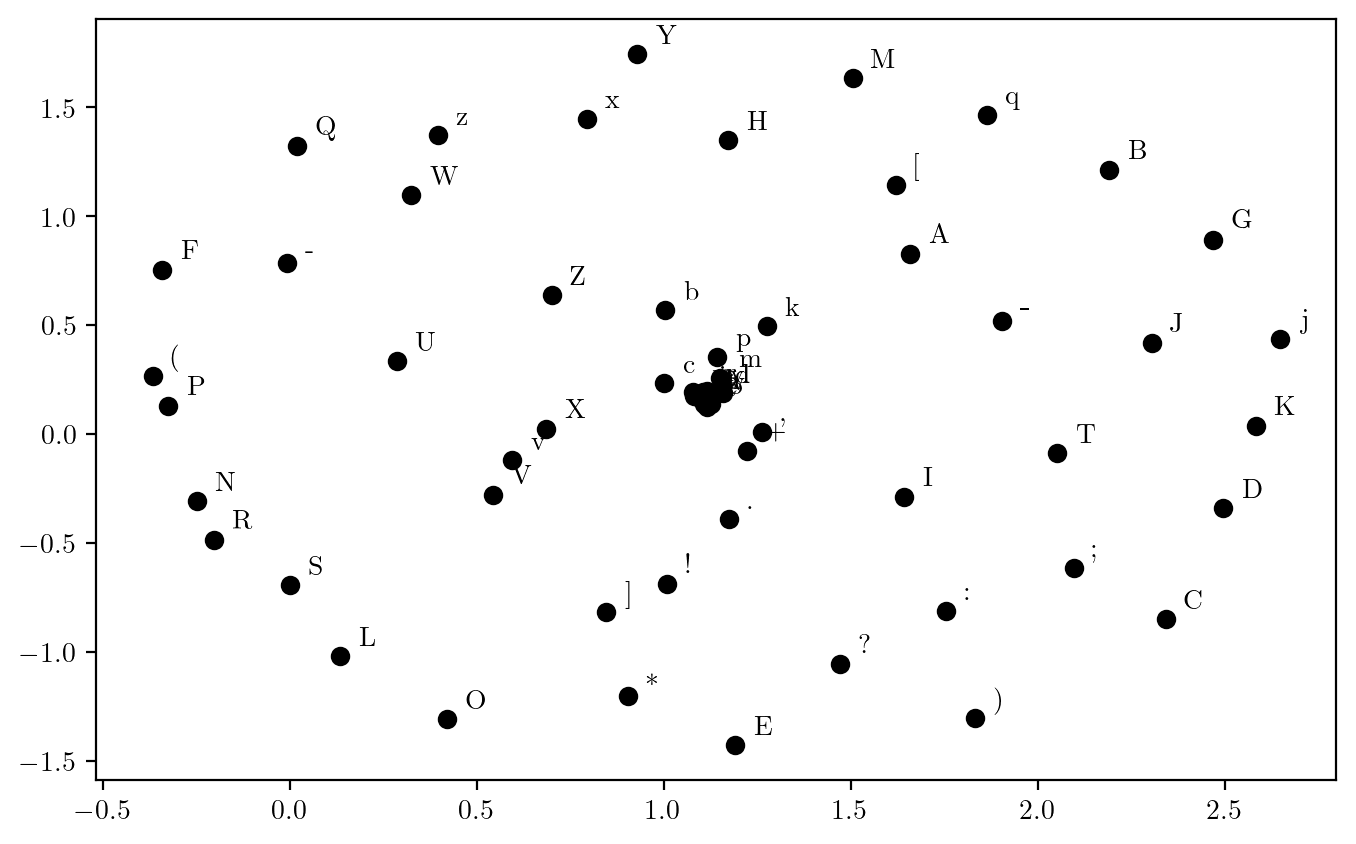

In [18]:
latexify(columns = 2, fig_width = 8)
plot_emb(model.emb, itos)

## Generating Strings from the Model

In [51]:
start = np.random.randint(0, len(new_wonder) - block_size - 1)
end = start + block_size
while new_wonder[start] != " ":
  start += 1

while new_wonder[end] != " ":
  end -= 1

seed_text = new_wonder[start + 1 : end]
print(f"==================Seed Text=================\n{seed_text}\n")
my_str = generate_text(model, itos, stoi, block_size, 1000, seed_text)
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(f"\n===============Predicted Text===============\n{decoded_string}")

==================Seed Text=================
right! shouted the Queen. Can you play croquet?

The soldiers were silent, and looked at


===============Predicted Text===============
right! shouted the Queen. Can you play croquet?

The soldiers were silent, and looked at eocid tlad s ther of
themededng-shels mand ghtureasr, very that I so the qurttongergul to hpath thed goedenhthe los
dedrlytupbetine, ane matery, Snomi tatt to houdd.

Youre_ hemikntt,
Darpousian roued Alice was don at e, hout! a wapl
tha more heated fushe whure the srsadritht very he evreleg. Anice.

Hatthint ro cout inca coutaddy hhice ofr, phat _adrse tho knet tnin
co gir the
tound Alf ro they co _ hatdd hernd the wecr oed tobe the
ongo to sad sylk ad the gat euss an see muche in.
Ale! The ladd word hent by ay-tomighe bele thoudse gaided pin
in lh hem
In ok s perelun, she hat ut of to the, washand. Alich in idly
if rith,rsher hham houretroo ded o olled it Alich.

Alice rougnd ther mar, bll saly toro ooke, in heres ofs!